# MNIST

In this notebook, we built a Poon architecture SPN for a dataset created from PCA features of the MNIST handwritten digit dataset. Afterwards the parameters of the SPN are learned using the EM algorithm. This partially verifies the experiments conducted in section 7.1 of [1].


[1] Peharz, Robert. (2015). Foundations of Sum-Product Networks for Probabilistic Modeling. 

In [1]:
using SPN
using MNIST
using MultivariateStats
using Gadfly

In [2]:
x, y = traindata()

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64, ::Int64) at ./deprecated.jl:57
 [3] traindata() at /home/lefmann/.julia/v0.6/MNIST/src/MNIST.jl:88
 [4] include_string(::String, ::String) at ./loading.jl:522
 [5] include_string(::Module, ::String, ::String) at /home/lefmann/.julia/v0.6/Compat/src/Compat.jl:71
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/lefmann/.julia/v0.6/IJulia/src/execute_request.jl:158
 [7] (::Compat.#inner#17{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/lefmann/.julia/v0.6/Compat/src/Compat.jl:385
 [8] eventloop(::ZMQ.Socket) at /home/lefmann/.julia/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##14#17)() at ./task.jl:335
while loading In[2], in expression starting on line 1
Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64) at ./deprecated.jl:57
 [3] traindata() at /home/lefmann/.julia/v0.6/MNIST/src/MNIST.jl:8

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [5.0, 0.0, 4.0, 1.0, 9.0, 2.0, 1.0, 3.0, 1.0, 4.0  …  9.0, 2.0, 9.0, 5.0, 1.0, 8.0, 3.0, 5.0, 6.0, 8.0])

In [3]:
@show size(x)
@show size(y)

size(x) = (784, 60000)
size(y) = (60000,)


(60000,)

In [4]:
pcaModel = fit(PCA, x; maxoutdim=9)

PCA(indim = 784, outdim = 9, principalratio = 0.46458)

In [5]:
xTransformed = transform(pcaModel, x)

9×60000 Array{Float64,2}:
  123.933   1011.72     -51.8496   …  -178.053    130.606    -173.436 
  312.674    294.857   -392.173       -160.078      5.59194    24.7188
   24.5141  -596.34     188.51         257.613   -513.859    -556.019 
  555.758    460.766   -521.011        714.65    -342.704     120.862 
  -27.2967  -827.275   -306.681       -210.315   -521.166    -198.0   
  232.476    181.951      1.83535  …   462.463    540.554    -233.026 
  233.996    -45.0205  -859.047       -464.535   -107.376    -461.44  
 -159.799    104.97    -368.592        184.823   -140.729     154.455 
 -363.515     40.4591  -114.546        -87.5243   -16.4958     87.3036

In [6]:
# swap rows and columns:
x = xTransformed'

60000×9 Array{Float64,2}:
  123.933    312.674      24.5141  …   233.996   -159.799    -363.515 
 1011.72     294.857    -596.34        -45.0205   104.97       40.4591
  -51.8496  -392.173     188.51       -859.047   -368.592    -114.546 
 -799.127    607.197    -273.651      -473.713     67.3217    302.731 
 -382.755   -730.543     -16.3537      -91.6666   405.555     225.502 
  184.469   -221.332    -591.36    …   -31.6223   -98.5792    -47.0293
 -726.514    156.986     248.191       356.04     156.894    -226.846 
  513.345    310.773     104.08       -502.436   -250.842    -494.308 
 -868.907     81.5472    133.418       124.991    219.185    -229.229 
 -304.731   -465.597    -692.383      -446.21     -55.3147    -30.7534
 -146.202    643.426     251.311   …   395.08    -572.065    -106.959 
 -613.839    243.373    -344.926      -360.696    -47.2552    155.174 
  279.92     830.688    1106.71         62.1792  -373.897     454.063 
    ⋮                              ⋱               

# Normalize

Normalize the dataset such that each variable (column) has mean 0 and variance 1.

In [7]:
@show mean(x,1)
@show var(x,1);

mean(x, 1) = [-1.1399e-13 2.60722e-14 -5.72375e-14 1.94026e-14 -3.73499e-14 1.01863e-14 1.94026e-15 -5.45697e-16 -1.30967e-14]
var(x, 1) = [3.32725e5 2.43284e5 2.11507e5 1.84776e5 1.66927e5 147845.0 1.12178e5 98874.4 94696.2]


In [8]:
function normalizeDataset!(x::AbstractArray)
    x = x .- mean(x,1)
    x = x
    return x ./ std(x,1)
end

normalizeDataset! (generic function with 1 method)

In [9]:
x = normalizeDataset!(x)
x = x[1:1000,:]

1000×9 Array{Float64,2}:
  0.214854    0.633921    0.0533031  …   0.69864    -0.508199   -1.18129  
  1.75395     0.597798   -1.29667       -0.134418    0.333827    0.131477 
 -0.0898883  -0.795099    0.409894      -2.56485    -1.17221    -0.372232 
 -1.38539     1.23104    -0.595024      -1.41436     0.214098    0.983764 
 -0.663557   -1.48112    -0.0355594     -0.273689    1.28976     0.732797 
  0.319802   -0.448732   -1.28585    …  -0.0944145  -0.313504   -0.152828 
 -1.25951     0.318275    0.539663       1.06303     0.498958   -0.737165 
  0.889952    0.630067    0.226311      -1.50012    -0.797733   -1.60632  
 -1.50637     0.16533     0.290102       0.373186    0.697056   -0.744909 
 -0.528291   -0.94396    -1.50551       -1.33225    -0.175913   -0.0999372
 -0.253461    1.30449     0.546448   …   1.17959    -1.8193     -0.347578 
 -1.06417     0.493418   -0.750004      -1.07693    -0.150282    0.504258 
  0.485279    1.68415     2.40641        0.185648   -1.18908     1.47554  


In [10]:
spn = structureLearnPoon(x,3,3,nsum=5,nleaf=10,baseres=1)

Generating decompositions ... done
Generating SPN ...done


SumProductNetwork(size=2621)

In [11]:
llhvals = parameterLearnEM!(spn, x)

iteration 1:	 llh=-13353
iteration 2:	 llh=-13214
iteration 3:	 llh=-13122
iteration 4:	 llh=-13060
iteration 5:	 llh=-13016
iteration 6:	 llh=-12984
iteration 7:	 llh=-12960
iteration 8:	 llh=-12942
iteration 9:	 llh=-12927
iteration 10:	 llh=-12915
iteration 11:	 llh=-12906
iteration 12:	 llh=-12898
iteration 13:	 llh=-12891
iteration 14:	 llh=-12885
iteration 15:	 llh=-12880
iteration 16:	 llh=-12875
iteration 17:	 llh=-12872
iteration 18:	 llh=-12868
iteration 19:	 llh=-12865
iteration 20:	 llh=-12862
iteration 21:	 llh=-12859
iteration 22:	 llh=-12857
iteration 23:	 llh=-12855
iteration 24:	 llh=-12853
iteration 25:	 llh=-12851
iteration 26:	 llh=-12850
iteration 27:	 llh=-12848
iteration 28:	 llh=-12847
iteration 29:	 llh=-12845
iteration 30:	 llh=-12844


30-element Array{Float64,1}:
 -13352.5
 -13213.6
 -13122.3
 -13060.1
 -13016.1
 -12984.1
 -12960.1
 -12941.7
 -12927.1
 -12915.4
 -12905.8
 -12897.7
 -12890.9
      ⋮  
 -12864.9
 -12862.0
 -12859.5
 -12857.1
 -12855.0
 -12853.1
 -12851.3
 -12849.6
 -12848.1
 -12846.7
 -12845.4
 -12844.2

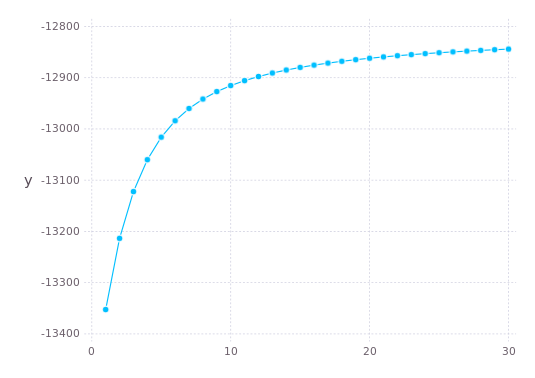

In [12]:
plot(y=llhvals, Geom.point, Geom.line)